# Method 8 - Best Ideas High Minus Low Focus

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Focus

focus = inst_data.groupby(['datadate', 'institution_id'])['fsym_id'].count().rename('focus').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Use Raw Weight

valid_data['adj_target'] = valid_data['target']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Focus

best_ideas = best_ideas.merge(focus)
best_ideas['focus_pct'] = best_ideas.groupby('datadate')['focus'].rank(pct=True)
low_ideas = best_ideas[best_ideas['focus_pct'] < (1 / 3)]
high_ideas = best_ideas[best_ideas['focus_pct'] > (2 / 3)]

# Weight the best ideas equally

low_ideas['target'] = 1 / low_ideas.groupby('datadate')['institution_id'].transform('count')
high_ideas['target'] = 1 / high_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
low_w = weights.Weights(low_ideas)
high_w = weights.Weights(high_ideas)

%store -r r

low_p = portfolio.DailyPortfolio(low_w, r, end_date='2018-12-31')
high_p = portfolio.DailyPortfolio(high_w, r, end_date='2018-12-31')

monthly_return = (high_p.port_return - low_p.port_return).loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

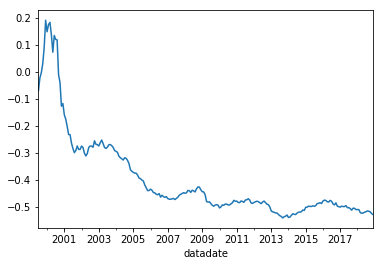

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.190661
2000-12-31   -0.259262
2001-12-31   -0.192714
2002-12-31    0.024299
2003-12-31   -0.029821
2004-12-31   -0.109004
2005-12-31   -0.112720
2006-12-31   -0.040531
2007-12-31    0.027270
2008-12-31    0.019710
2009-12-31   -0.101722
2010-12-31    0.028159
2011-12-31   -0.014623
2012-12-31   -0.025559
2013-12-31   -0.060258
2014-12-31    0.036550
2015-12-31    0.052145
2016-12-31   -0.022828
2017-12-31   -0.021611
2018-12-31   -0.038869
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     8.525
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.98e-06
Time:                        07:08:57   Log-Likelihood:                 606.17
No. Observations:                 234   AIC:                            -1202.
Df Residuals:                     229   BIC:                            -1185.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0029      0.001     -2.302      0.022      -0.005      -0.000
mktrf          0.0520      0.034      1.520      0.130      -0.015       0.119
me            -0.0311      0.040     -0.781      0.436      -0.109       0.047
ia            -0.3219      0.060     -5.323      0.000      -0.441      -0.203
roe            0.1109      0.052      2.142      0.033       0.009       0.213
==============================================================================
Omnibus:                       46.903   Durbin-Watson:                   1.740
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              344.265
Skew:                          -0.494   Prob(JB):                     1.75e-75
Kurtosis:                       8.859   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     7.225
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.70e-05
Time:                        07:08:57   Log-Likelihood:                 606.17
No. Observations:                 234   AIC:                            -1202.
Df Residuals:                     229   BIC:                            -1185.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0029      0.002     -1.750      0.080      -0.006       0.000
mktrf          0.0520      0.040      1.310      0.190      -0.026       0.130
me            -0.0311      0.052     -0.592      0.554      -0.134       0.072
ia            -0.3219      0.139     -2.310      0.021      -0.595      -0.049
roe            0.1109      0.040      2.752      0.006       0.032       0.190
==============================================================================
Omnibus:                       46.903   Durbin-Watson:                   1.740
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              344.265
Skew:                          -0.494   Prob(JB):                     1.75e-75
Kurtosis:                       8.859   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     10.10
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.52e-07
Time:                        07:08:57   Log-Likelihood:                 606.17
No. Observations:                 234   AIC:                            -1202.
Df Residuals:                     229   BIC:                            -1185.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0029      0.002     -1.779      0.075      -0.006       0.000
mktrf          0.0520      0.043      1.217      0.224      -0.032       0.136
me            -0.0311      0.047     -0.667      0.505      -0.122       0.060
ia            -0.3219      0.152     -2.121      0.034      -0.619      -0.024
roe            0.1109      0.036      3.102      0.002       0.041       0.181
==============================================================================
Omnibus:                       46.903   Durbin-Watson:                   1.740
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              344.265
Skew:                          -0.494   Prob(JB):                     1.75e-75
Kurtosis:                       8.859   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     10.47
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.62e-09
Time:                        07:08:57   Log-Likelihood:                 614.12
No. Observations:                 234   AIC:                            -1216.
Df Residuals:                     228   BIC:                            -1196.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.001     -1.723      0.086      -0.005       0.000
mktrf          0.0187      0.033      0.563      0.574      -0.047       0.084
smb           -0.0650      0.044     -1.483      0.139      -0.151       0.021
hml           -0.1877      0.052     -3.634      0.000      -0.289      -0.086
rmw           -0.0227      0.058     -0.389      0.698      -0.138       0.092
cma           -0.1172      0.074     -1.579      0.116      -0.264       0.029
==============================================================================
Omnibus:                       50.177   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              320.096
Skew:                          -0.619   Prob(JB):                     3.11e-70
Kurtosis:                       8.594   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     8.276
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.33e-07
Time:                        07:08:57   Log-Likelihood:                 614.12
No. Observations:                 234   AIC:                            -1216.
Df Residuals:                     228   BIC:                            -1196.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.001     -1.611      0.107      -0.005       0.000
mktrf          0.0187      0.039      0.485      0.628      -0.057       0.094
smb           -0.0650      0.048     -1.354      0.176      -0.159       0.029
hml           -0.1877      0.068     -2.757      0.006      -0.321      -0.054
rmw           -0.0227      0.059     -0.386      0.699      -0.138       0.093
cma           -0.1172      0.111     -1.059      0.290      -0.334       0.100
==============================================================================
Omnibus:                       50.177   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              320.096
Skew:                          -0.619   Prob(JB):                     3.11e-70
Kurtosis:                       8.594   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     10.84
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.30e-09
Time:                        07:08:57   Log-Likelihood:                 614.12
No. Observations:                 234   AIC:                            -1216.
Df Residuals:                     228   BIC:                            -1196.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.001     -1.662      0.096      -0.005       0.000
mktrf          0.0187      0.041      0.454      0.650      -0.062       0.099
smb           -0.0650      0.034     -1.916      0.055      -0.131       0.001
hml           -0.1877      0.070     -2.673      0.008      -0.325      -0.050
rmw           -0.0227      0.057     -0.398      0.691      -0.135       0.089
cma           -0.1172      0.108     -1.084      0.278      -0.329       0.095
==============================================================================
Omnibus:                       50.177   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              320.096
Skew:                          -0.619   Prob(JB):                     3.11e-70
Kurtosis:                       8.594   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     23.44
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.94e-16
Time:                        07:08:57   Log-Likelihood:                 630.09
No. Observations:                 234   AIC:                            -1250.
Df Residuals:                     229   BIC:                            -1233.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0035      0.001     -3.140      0.002      -0.006      -0.001
mktrf          0.1088      0.028      3.827      0.000       0.053       0.165
smb           -0.0955      0.035     -2.692      0.008      -0.165      -0.026
hml           -0.2191      0.035     -6.215      0.000      -0.289      -0.150
umd            0.1428      0.023      6.175      0.000       0.097       0.188
==============================================================================
Omnibus:                       66.255   Durbin-Watson:                   1.780
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              494.743
Skew:                          -0.864   Prob(JB):                    3.70e-108
Kurtosis:                       9.911   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     10.59
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.85e-08
Time:                        07:08:57   Log-Likelihood:                 630.09
No. Observations:                 234   AIC:                            -1250.
Df Residuals:                     229   BIC:                            -1233.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0035      0.001     -2.538      0.011      -0.006      -0.001
mktrf          0.1088      0.054      1.997      0.046       0.002       0.216
smb           -0.0955      0.030     -3.137      0.002      -0.155      -0.036
hml           -0.2191      0.065     -3.370      0.001      -0.347      -0.092
umd            0.1428      0.036      3.968      0.000       0.072       0.213
==============================================================================
Omnibus:                       66.255   Durbin-Watson:                   1.780
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              494.743
Skew:                          -0.864   Prob(JB):                    3.70e-108
Kurtosis:                       9.911   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     11.16
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.76e-08
Time:                        07:08:57   Log-Likelihood:                 630.09
No. Observations:                 234   AIC:                            -1250.
Df Residuals:                     229   BIC:                            -1233.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0035      0.001     -2.405      0.016      -0.006      -0.001
mktrf          0.1088      0.064      1.703      0.089      -0.016       0.234
smb           -0.0955      0.026     -3.617      0.000      -0.147      -0.044
hml           -0.2191      0.077     -2.843      0.004      -0.370      -0.068
umd            0.1428      0.042      3.398      0.001       0.060       0.225
==============================================================================
Omnibus:                       66.255   Durbin-Watson:                   1.780
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              494.743
Skew:                          -0.864   Prob(JB):                    3.70e-108
Kurtosis:                       9.911   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     4.991
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           0.000956
Time:                        07:08:57   Log-Likelihood:                 281.00
No. Observations:                 120   AIC:                            -552.0
Df Residuals:                     115   BIC:                            -538.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0043      0.002     -1.905      0.059      -0.009       0.000
mktrf          0.0543      0.061      0.886      0.378      -0.067       0.176
me             0.0012      0.061      0.020      0.984      -0.119       0.121
ia            -0.3946      0.095     -4.165      0.000      -0.582      -0.207
roe            0.1196      0.084      1.426      0.156      -0.046       0.286
==============================================================================
Omnibus:                       13.957   Durbin-Watson:                   1.786
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               34.189
Skew:                          -0.344   Prob(JB):                     3.77e-08
Kurtosis:                       5.523   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     2.872
Date:                Tue, 28 Apr 2020   Prob (F-statistic):             0.0261
Time:                        07:08:58   Log-Likelihood:                 281.00
No. Observations:                 120   AIC:                            -552.0
Df Residuals:                     115   BIC:                            -538.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0043      0.003     -1.426      0.154      -0.010       0.002
mktrf          0.0543      0.077      0.701      0.484      -0.098       0.206
me             0.0012      0.060      0.020      0.984      -0.116       0.119
ia            -0.3946      0.178     -2.212      0.027      -0.744      -0.045
roe            0.1196      0.067      1.781      0.075      -0.012       0.251
==============================================================================
Omnibus:                       13.957   Durbin-Watson:                   1.786
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               34.189
Skew:                          -0.344   Prob(JB):                     3.77e-08
Kurtosis:                       5.523   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     3.427
Date:                Tue, 28 Apr 2020   Prob (F-statistic):             0.0110
Time:                        07:08:58   Log-Likelihood:                 281.00
No. Observations:                 120   AIC:                            -552.0
Df Residuals:                     115   BIC:                            -538.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0043      0.003     -1.480      0.139      -0.010       0.001
mktrf          0.0543      0.087      0.623      0.534      -0.117       0.225
me             0.0012      0.056      0.022      0.983      -0.109       0.111
ia            -0.3946      0.189     -2.083      0.037      -0.766      -0.023
roe            0.1196      0.066      1.818      0.069      -0.009       0.249
==============================================================================
Omnibus:                       13.957   Durbin-Watson:                   1.786
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               34.189
Skew:                          -0.344   Prob(JB):                     3.77e-08
Kurtosis:                       5.523   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     6.102
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.81e-05
Time:                        07:08:58   Log-Likelihood:                 285.62
No. Observations:                 120   AIC:                            -559.2
Df Residuals:                     114   BIC:                            -542.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0029      0.002     -1.280      0.203      -0.007       0.002
mktrf         -0.0106      0.062     -0.169      0.866      -0.134       0.113
smb           -0.0577      0.071     -0.816      0.416      -0.198       0.082
hml           -0.1960      0.087     -2.262      0.026      -0.368      -0.024
rmw           -0.0554      0.102     -0.542      0.589      -0.258       0.147
cma           -0.1586      0.112     -1.417      0.159      -0.380       0.063
==============================================================================
Omnibus:                       17.683   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.779
Skew:                          -0.511   Prob(JB):                     5.14e-10
Kurtosis:                       5.741   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     10.10
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.00e-08
Time:                        07:08:58   Log-Likelihood:                 285.62
No. Observations:                 120   AIC:                            -559.2
Df Residuals:                     114   BIC:                            -542.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0029      0.002     -1.221      0.222      -0.008       0.002
mktrf         -0.0106      0.082     -0.129      0.897      -0.171       0.150
smb           -0.0577      0.066     -0.870      0.384      -0.188       0.072
hml           -0.1960      0.126     -1.559      0.119      -0.442       0.050
rmw           -0.0554      0.123     -0.451      0.652      -0.296       0.185
cma           -0.1586      0.148     -1.073      0.283      -0.448       0.131
==============================================================================
Omnibus:                       17.683   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.779
Skew:                          -0.511   Prob(JB):                     5.14e-10
Kurtosis:                       5.741   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     16.24
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.51e-12
Time:                        07:08:58   Log-Likelihood:                 285.62
No. Observations:                 120   AIC:                            -559.2
Df Residuals:                     114   BIC:                            -542.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0029      0.002     -1.307      0.191      -0.007       0.001
mktrf         -0.0106      0.087     -0.121      0.904      -0.182       0.161
smb           -0.0577      0.047     -1.215      0.224      -0.151       0.035
hml           -0.1960      0.128     -1.532      0.126      -0.447       0.055
rmw           -0.0554      0.114     -0.486      0.627      -0.279       0.168
cma           -0.1586      0.150     -1.059      0.290      -0.452       0.135
==============================================================================
Omnibus:                       17.683   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.779
Skew:                          -0.511   Prob(JB):                     5.14e-10
Kurtosis:                       5.741   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     16.29
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.34e-10
Time:                        07:08:58   Log-Likelihood:                 298.33
No. Observations:                 120   AIC:                            -586.7
Df Residuals:                     115   BIC:                            -572.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0042      0.002     -2.198      0.030      -0.008      -0.000
mktrf          0.1586      0.047      3.395      0.001       0.066       0.251
smb           -0.1153      0.053     -2.168      0.032      -0.221      -0.010
hml           -0.2602      0.053     -4.884      0.000      -0.366      -0.155
umd            0.1807      0.033      5.502      0.000       0.116       0.246
==============================================================================
Omnibus:                       25.845   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.093
Skew:                          -0.664   Prob(JB):                     7.43e-20
Kurtosis:                       6.982   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     7.992
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.01e-05
Time:                        07:08:58   Log-Likelihood:                 298.33
No. Observations:                 120   AIC:                            -586.7
Df Residuals:                     115   BIC:                            -572.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0042      0.002     -2.077      0.038      -0.008      -0.000
mktrf          0.1586      0.077      2.070      0.038       0.008       0.309
smb           -0.1153      0.049     -2.374      0.018      -0.211      -0.020
hml           -0.2602      0.076     -3.402      0.001      -0.410      -0.110
umd            0.1807      0.046      3.960      0.000       0.091       0.270
==============================================================================
Omnibus:                       25.845   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.093
Skew:                          -0.664   Prob(JB):                     7.43e-20
Kurtosis:                       6.982   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     7.581
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.86e-05
Time:                        07:08:58   Log-Likelihood:                 298.33
No. Observations:                 120   AIC:                            -586.7
Df Residuals:                     115   BIC:                            -572.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0042      0.002     -2.129      0.033      -0.008      -0.000
mktrf          0.1586      0.089      1.792      0.073      -0.015       0.332
smb           -0.1153      0.053     -2.185      0.029      -0.219      -0.012
hml           -0.2602      0.088     -2.947      0.003      -0.433      -0.087
umd            0.1807      0.054      3.360      0.001       0.075       0.286
==============================================================================
Omnibus:                       25.845   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.093
Skew:                          -0.664   Prob(JB):                     7.43e-20
Kurtosis:                       6.982   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     8.414
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.93e-06
Time:                        07:08:58   Log-Likelihood:                 379.89
No. Observations:                 114   AIC:                            -749.8
Df Residuals:                     109   BIC:                            -736.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.001     -1.734      0.086      -0.003       0.000
mktrf          0.0389      0.026      1.498      0.137      -0.013       0.090
me            -0.0822      0.040     -2.050      0.043      -0.162      -0.003
ia            -0.0620      0.056     -1.114      0.268      -0.172       0.048
roe            0.2117      0.049      4.331      0.000       0.115       0.309
==============================================================================
Omnibus:                        0.741   Durbin-Watson:                   1.739
Prob(Omnibus):                  0.690   Jarque-Bera (JB):                0.331
Skew:                           0.005   Prob(JB):                        0.847
Kurtosis:                       3.264   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     10.56
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.87e-07
Time:                        07:08:58   Log-Likelihood:                 379.89
No. Observations:                 114   AIC:                            -749.8
Df Residuals:                     109   BIC:                            -736.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.001     -1.353      0.176      -0.004       0.001
mktrf          0.0389      0.029      1.354      0.176      -0.017       0.095
me            -0.0822      0.049     -1.676      0.094      -0.178       0.014
ia            -0.0620      0.062     -1.000      0.317      -0.183       0.059
roe            0.2117      0.047      4.512      0.000       0.120       0.304
==============================================================================
Omnibus:                        0.741   Durbin-Watson:                   1.739
Prob(Omnibus):                  0.690   Jarque-Bera (JB):                0.331
Skew:                           0.005   Prob(JB):                        0.847
Kurtosis:                       3.264   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     10.73
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.26e-07
Time:                        07:08:58   Log-Likelihood:                 379.89
No. Observations:                 114   AIC:                            -749.8
Df Residuals:                     109   BIC:                            -736.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.001     -1.176      0.240      -0.004       0.001
mktrf          0.0389      0.028      1.391      0.164      -0.016       0.094
me            -0.0822      0.048     -1.722      0.085      -0.176       0.011
ia            -0.0620      0.062     -0.996      0.319      -0.184       0.060
roe            0.2117      0.047      4.525      0.000       0.120       0.303
==============================================================================
Omnibus:                        0.741   Durbin-Watson:                   1.739
Prob(Omnibus):                  0.690   Jarque-Bera (JB):                0.331
Skew:                           0.005   Prob(JB):                        0.847
Kurtosis:                       3.264   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     9.241
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.40e-07
Time:                        07:08:58   Log-Likelihood:                 384.85
No. Observations:                 114   AIC:                            -757.7
Df Residuals:                     108   BIC:                            -741.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.001     -1.724      0.088      -0.003       0.000
mktrf          0.0353      0.024      1.480      0.142      -0.012       0.083
smb           -0.0659      0.039     -1.703      0.092      -0.143       0.011
hml           -0.0282      0.049     -0.572      0.568      -0.126       0.070
rmw            0.2864      0.060      4.741      0.000       0.167       0.406
cma           -0.0877      0.077     -1.144      0.255      -0.240       0.064
==============================================================================
Omnibus:                        0.243   Durbin-Watson:                   1.771
Prob(Omnibus):                  0.886   Jarque-Bera (JB):                0.035
Skew:                           0.013   Prob(JB):                        0.983
Kurtosis:                       3.082   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     13.52
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.07e-10
Time:                        07:08:58   Log-Likelihood:                 384.85
No. Observations:                 114   AIC:                            -757.7
Df Residuals:                     108   BIC:                            -741.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.001     -1.408      0.159      -0.004       0.001
mktrf          0.0353      0.026      1.332      0.183      -0.017       0.087
smb           -0.0659      0.049     -1.344      0.179      -0.162       0.030
hml           -0.0282      0.056     -0.502      0.615      -0.138       0.082
rmw            0.2864      0.060      4.753      0.000       0.168       0.404
cma           -0.0877      0.101     -0.868      0.386      -0.286       0.110
==============================================================================
Omnibus:                        0.243   Durbin-Watson:                   1.771
Prob(Omnibus):                  0.886   Jarque-Bera (JB):                0.035
Skew:                           0.013   Prob(JB):                        0.983
Kurtosis:                       3.082   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     21.63
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.98e-15
Time:                        07:08:58   Log-Likelihood:                 384.85
No. Observations:                 114   AIC:                            -757.7
Df Residuals:                     108   BIC:                            -741.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.001     -1.251      0.211      -0.004       0.001
mktrf          0.0353      0.029      1.231      0.218      -0.021       0.091
smb           -0.0659      0.048     -1.381      0.167      -0.159       0.028
hml           -0.0282      0.048     -0.585      0.559      -0.123       0.066
rmw            0.2864      0.064      4.488      0.000       0.161       0.411
cma           -0.0877      0.103     -0.853      0.393      -0.289       0.114
==============================================================================
Omnibus:                        0.243   Durbin-Watson:                   1.771
Prob(Omnibus):                  0.886   Jarque-Bera (JB):                0.035
Skew:                           0.013   Prob(JB):                        0.983
Kurtosis:                       3.082   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     5.574
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           0.000404
Time:                        07:08:58   Log-Likelihood:                 375.16
No. Observations:                 114   AIC:                            -740.3
Df Residuals:                     109   BIC:                            -726.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.001     -1.299      0.197      -0.003       0.001
mktrf          0.0229      0.026      0.891      0.375      -0.028       0.074
smb           -0.1296      0.040     -3.239      0.002      -0.209      -0.050
hml           -0.0794      0.041     -1.926      0.057      -0.161       0.002
umd            0.0499      0.031      1.607      0.111      -0.012       0.112
==============================================================================
Omnibus:                        0.323   Durbin-Watson:                   1.722
Prob(Omnibus):                  0.851   Jarque-Bera (JB):                0.104
Skew:                          -0.061   Prob(JB):                        0.949
Kurtosis:                       3.084   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     5.555
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           0.000415
Time:                        07:08:58   Log-Likelihood:                 375.16
No. Observations:                 114   AIC:                            -740.3
Df Residuals:                     109   BIC:                            -726.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.001     -0.988      0.323      -0.004       0.001
mktrf          0.0229      0.032      0.719      0.472      -0.039       0.085
smb           -0.1296      0.053     -2.448      0.014      -0.233      -0.026
hml           -0.0794      0.046     -1.733      0.083      -0.169       0.010
umd            0.0499      0.040      1.246      0.213      -0.029       0.129
==============================================================================
Omnibus:                        0.323   Durbin-Watson:                   1.722
Prob(Omnibus):                  0.851   Jarque-Bera (JB):                0.104
Skew:                          -0.061   Prob(JB):                        0.949
Kurtosis:                       3.084   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     11.37
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.46e-08
Time:                        07:08:58   Log-Likelihood:                 375.16
No. Observations:                 114   AIC:                            -740.3
Df Residuals:                     109   BIC:                            -726.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.001     -0.848      0.397      -0.004       0.002
mktrf          0.0229      0.033      0.698      0.485      -0.041       0.087
smb           -0.1296      0.051     -2.544      0.011      -0.229      -0.030
hml           -0.0794      0.040     -1.990      0.047      -0.158      -0.001
umd            0.0499      0.042      1.194      0.233      -0.032       0.132
==============================================================================
Omnibus:                        0.323   Durbin-Watson:                   1.722
Prob(Omnibus):                  0.851   Jarque-Bera (JB):                0.104
Skew:                          -0.061   Prob(JB):                        0.949
Kurtosis:                       3.084   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""